# Predição de Temperatura com CNN 1D - TinyML

**Projeto:** Sistema de Predição de Temperatura para Microcontroladores

**Objetivo:** Prever a temperatura do sensor AHT20 em 5, 10 e 15 minutos no futuro

**Sensores utilizados:**
- AHT20: Temperatura e Umidade
- BMP280: Temperatura e Pressão

**Modelo:** CNN 1D (Convolutional Neural Network 1D) compatível com TensorFlow Lite Micro

**Deploy:** Raspberry Pi Pico (RP2040)

---

# 1. Carregar os Dados

---

In [31]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# TensorFlow e Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Sklearn para pré-processamento e métricas
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Configurar seed para reprodutibilidade
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f'TensorFlow: {tf.__version__}')
print(f'Seed configurado: {SEED}')

TensorFlow: 2.20.0
Seed configurado: 42


In [32]:
#Carregar o dataset de temperatura em lê csv
df_raw = pd.read_csv('data/temp.csv')
df_raw['Timestamp'] = pd.to_datetime(df_raw['Timestamp'])#converter coluna de timestamp para datetime
print(f'Shape original: {df_raw.shape}')
print(f'Colunas disponíveis: {list(df_raw.columns)}')

Shape original: (82430, 12)
Colunas disponíveis: ['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C', 'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C', 'Umid_DHT11_pct']


- Vemos que o dataset completo tem várias colunas com vários dados de sensores. Como no nosso projeto só usaremos o AHT20 e BMP280 no RP2040, os outros sensores podem introduzir ruído. Para resolver isso, teremos que filtrar deixando apenas as features importantes.

- Além disso, usaremos também o Temp_Aht_20_c tanto como feature quanto como target do nosso projeto. Essa abordagem é válida porque trabalharemos com séries temporais e janelas deslizantes.

- Além disso, usaremos também o Temp_Aht_20_c como feature, além de ser o target do nosso projeto. A ideia aqui é que contribua também no treino visto que trabalharemos com séries temporais e janelas. Em modelos de séries temporais, os valores passados de temperatura servem como features para prever o valor futuro

In [33]:
#Selecionar apenas as features de interesse
features = ['Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa']
df = df_raw[['Timestamp'] + features].copy()

print(f'\nDataset filtrado:')
print(f'Shape: {df.shape}')
print(f'Features selecionadas: {features}')
print(f'Período dos dados: {df["Timestamp"].min()} até {df["Timestamp"].max()}')
print(f'\nPrimeiras linhas:')
df.head()


Dataset filtrado:
Shape: (82430, 5)
Features selecionadas: ['Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa']
Período dos dados: 2025-08-31 22:31:02 até 2025-09-30 16:52:09

Primeiras linhas:


,Timestamp,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa
0,2025-08-31 22:31:02,19.90,73.37,21.28,921.24
1,2025-08-31 22:31:33,19.97,75.57,21.48,921.12
2,2025-08-31 22:32:05,19.75,74.31,21.25,921.20
3,2025-08-31 22:32:36,19.55,74.77,21.07,921.15
4,2025-08-31 22:33:07,19.60,75.09,21.12,921.25


In [34]:
# Informações sobre as colunas do dataset
print('Informações do dataset:')
print(df.info())
print('Estatísticas descritivas:')
df.describe()

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82430 entries, 0 to 82429
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Timestamp         82430 non-null  datetime64[ns]
 1   Temp_AHT20_C      82430 non-null  float64       
 2   Umid_AHT20_pct    82430 non-null  float64       
 3   Temp_BMP280_C     82430 non-null  float64       
 4   Press_BMP280_hPa  82430 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.1 MB
None
Estatísticas descritivas:


,Timestamp,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa
count,82430,82430.000000,82430.000000,82430.000000,82430.000000
mean,2025-09-15 19:31:51.557382144,20.328970,65.946394,21.803339,918.146819
min,2025-08-31 22:31:02,13.440000,35.440000,15.120000,912.100000
25%,2025-09-08 08:52:53.750000128,17.610000,54.520000,19.160000,916.600000
50%,2025-09-15 19:19:27.500000,19.750000,68.950000,21.240000,918.300000
75%,2025-09-23 06:09:26.249999872,22.990000,77.310000,24.400000,919.790000
max,2025-09-30 16:52:09,29.390000,92.130000,30.590000,922.990000
std,NaN,3.452443,13.343084,3.350503,2.147400


- Vemos que não temos dados nulos no dataset, não sendo necessário maior tratamento de dados.

# 2. Análise Exploratória de Dados (EDA)

---

In [35]:
# Calcular frequência de amostragem
time_diffs = df['Timestamp'].diff()
print('\nDiferenças de tempo entre amostras consecutivas:')
print(time_diffs.value_counts().head(10))

avg_interval = time_diffs.median()
print(f'\nIntervalo mediano: {avg_interval}')


Diferenças de tempo entre amostras consecutivas:
Timestamp
0 days 00:00:31    66852
0 days 00:00:32    15576
0 days 00:13:43        1
Name: count, dtype: int64

Intervalo mediano: 0 days 00:00:31


- Vemos que a frequência de amostragem da coleta de dados dos sensores variou entre 31 e 32 segundos, sendo a média em 31 segundos. (Esse valor será importante para definir o horizonte de previsão. Exemplo: previsão de 5 minutos → 10 medições)

## 2.1. Visualização das Séries Temporais

In [36]:
import os
os.makedirs('images/Conv1D', exist_ok=True)# Criar pasta images/Conv1D se não existir para armazenar as imagens

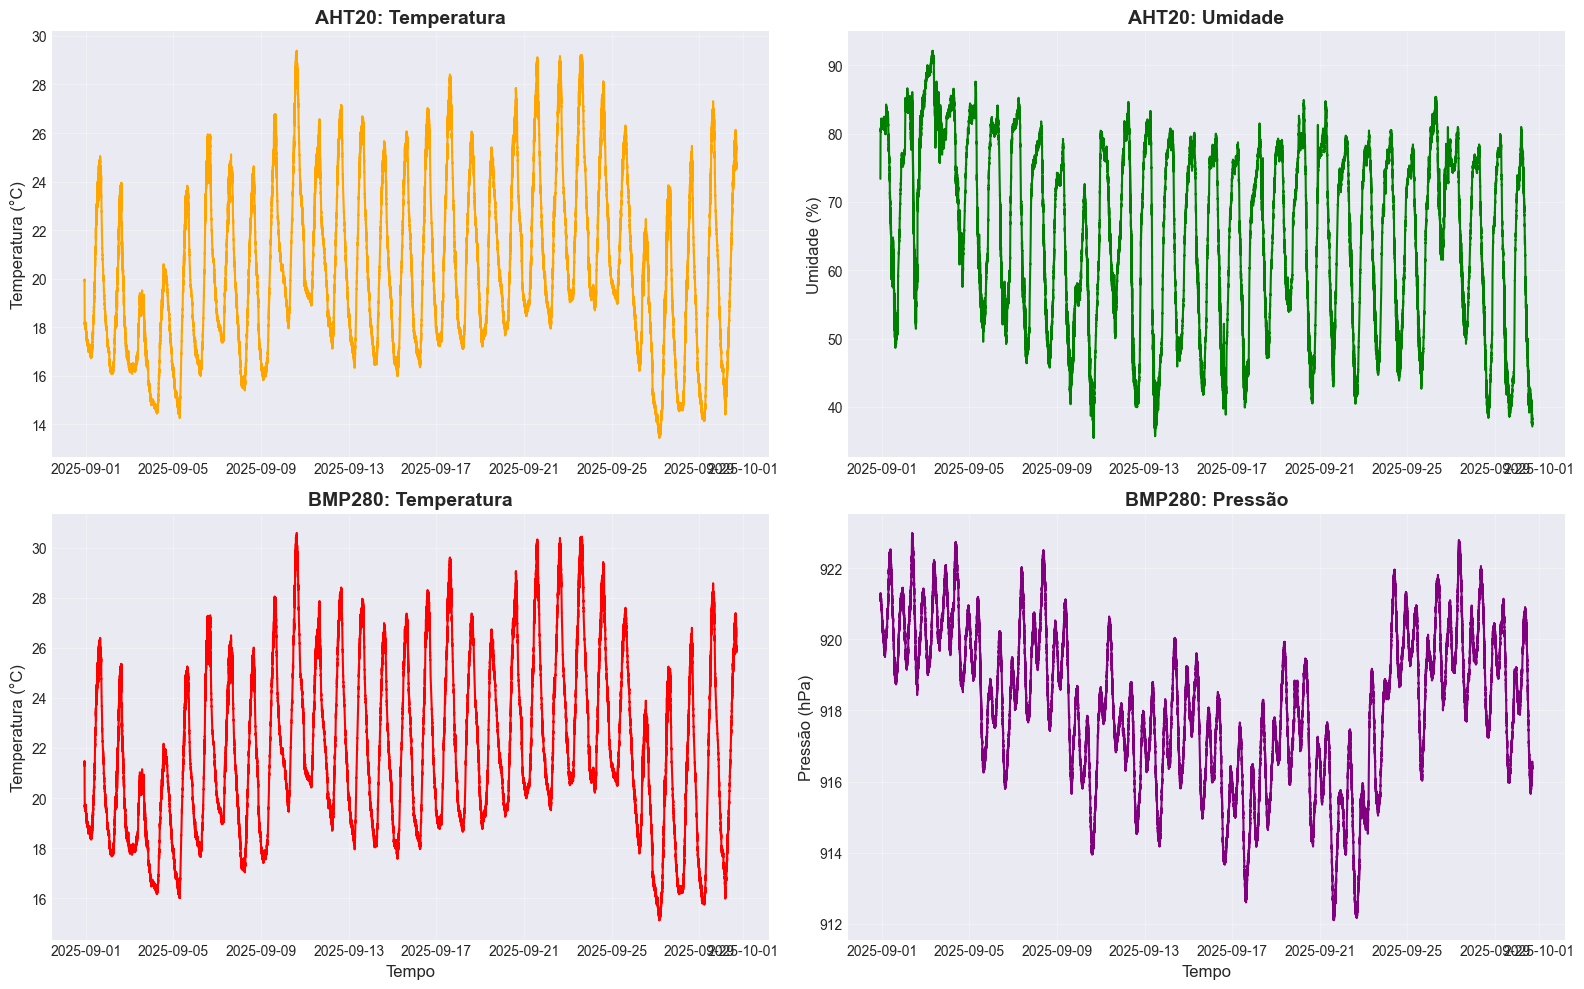

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))# Visualizar as séries temporais dos sensores

#AHT20: Temperatura
axes[0, 0].plot(df['Timestamp'], df['Temp_AHT20_C'], color='orange')
axes[0, 0].set_ylabel('Temperatura (°C)', fontsize=12)
axes[0, 0].set_title('AHT20: Temperatura', fontweight='bold', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

#AHT20: Umidade
axes[0, 1].plot(df['Timestamp'], df['Umid_AHT20_pct'], color='green')
axes[0, 1].set_ylabel('Umidade (%)', fontsize=12)
axes[0, 1].set_title('AHT20: Umidade', fontweight='bold', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# BMP280: Temperatura
axes[1, 0].plot(df['Timestamp'], df['Temp_BMP280_C'], color='red')
axes[1, 0].set_ylabel('Temperatura (°C)', fontsize=12)
axes[1, 0].set_xlabel('Tempo', fontsize=12)
axes[1, 0].set_title('BMP280: Temperatura', fontweight='bold', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# BMP280: Pressão
axes[1, 1].plot(df['Timestamp'], df['Press_BMP280_hPa'],color='purple')
axes[1, 1].set_ylabel('Pressão (hPa)', fontsize=12)
axes[1, 1].set_xlabel('Tempo', fontsize=12)
axes[1, 1].set_title('BMP280: Pressão', fontweight='bold', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/Conv1D/01_series_temporais.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.2. Distribuição das Features

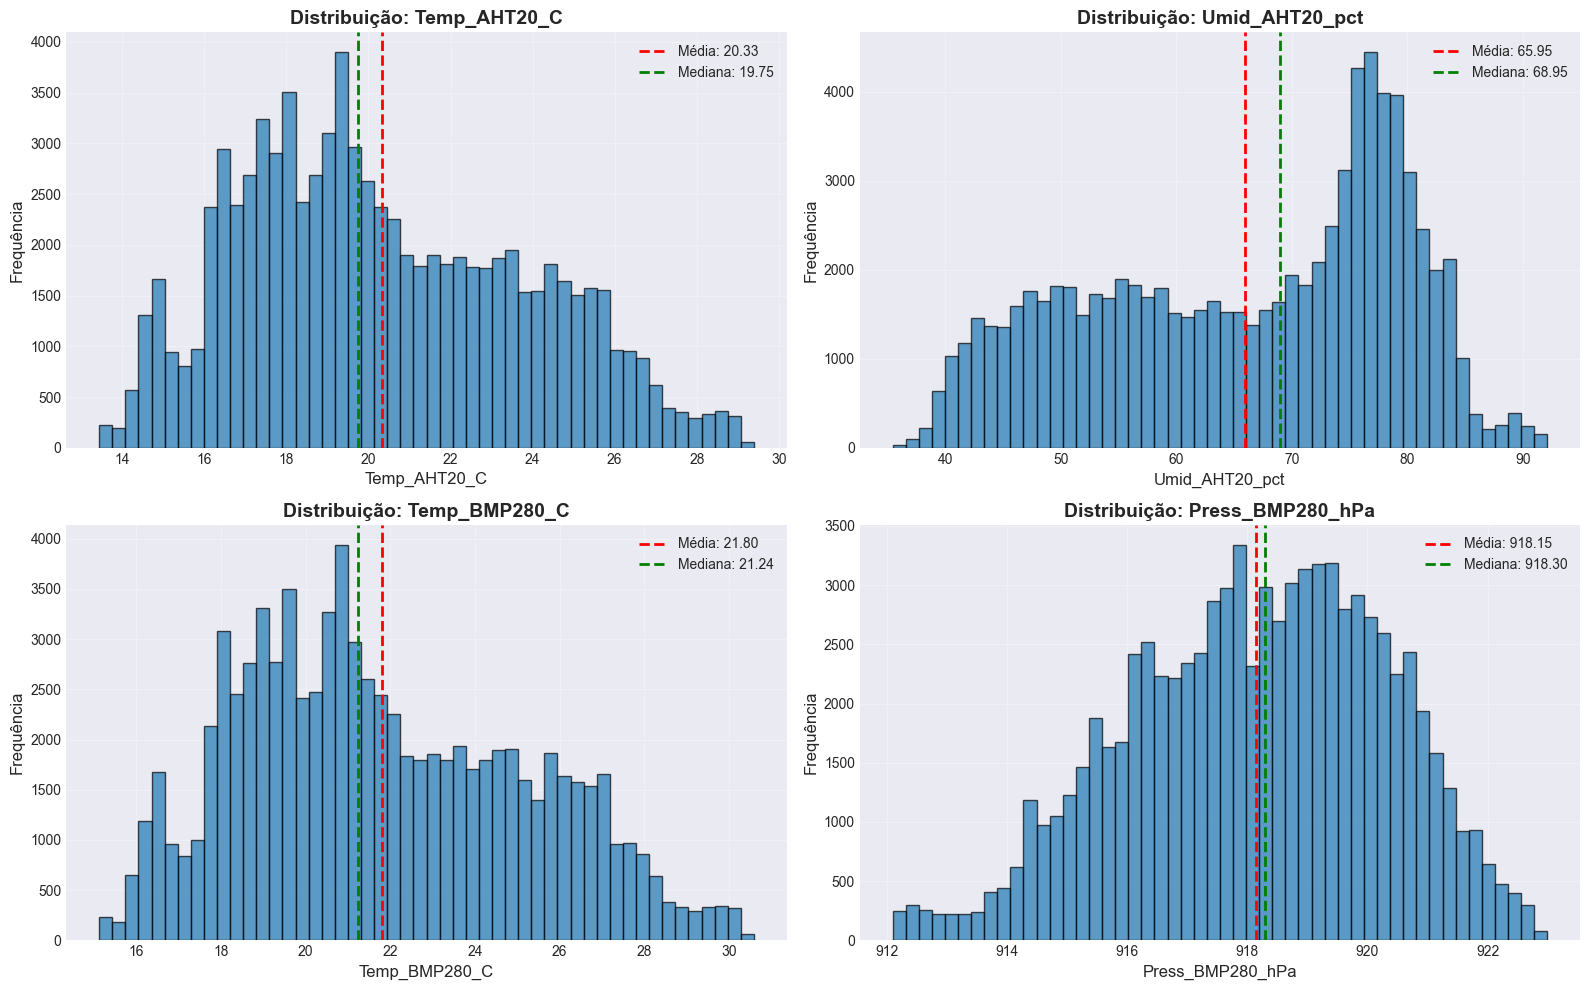

In [38]:
#Visualizar distribuição das features
fig, axes = plt.subplots(2, 2, figsize=(16, 10)) #subplots de distribuição
axes = axes.flatten()

for idx, feature in enumerate(features): #for para gerar distribuição para cada feature
    axes[idx].hist(df[feature], bins=50, alpha=0.7, edgecolor='black') #50 pedaços
    axes[idx].axvline(df[feature].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df[feature].mean():.2f}') #Reta media
    axes[idx].axvline(df[feature].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df[feature].median():.2f}') #reta mediana
    axes[idx].set_xlabel(feature, fontsize=12)
    axes[idx].set_ylabel('Frequência', fontsize=12)
    axes[idx].set_title(f'Distribuição: {feature}', fontweight='bold', fontsize=14)
    axes[idx].legend() #mostra legenda
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/Conv1D/02_distribuicao_features.png', dpi=300, bbox_inches='tight')
plt.show()

- As distribuições de temperatura (Temp_AHT20_C e Temp_BMP280_C) e pressão (Press_BMP280_hPa) apresentam formato aproximadamente normal, com médias próximas às medianas, indicando simetria. Já a umidade (Umid_AHT20_pct) mostra distribuição assimétrica à esquerda (média 65.95 vs mediana 68.95), sugerindo necessidade de normalização para melhor desempenho do modelo.

## 2.3. Matriz de Correlação

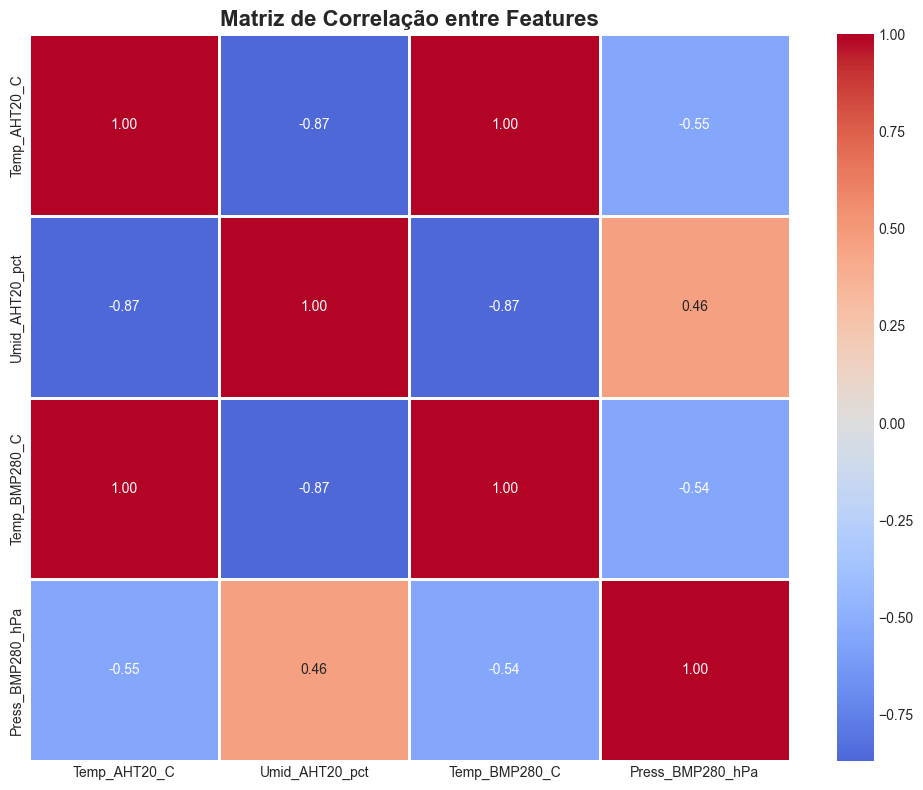


Correlações mais fortes com Temp_AHT20_C (target):
Temp_AHT20_C        1.000000
Temp_BMP280_C       0.999918
Press_BMP280_hPa   -0.547381
Umid_AHT20_pct     -0.869633
Name: Temp_AHT20_C, dtype: float64


In [39]:
# Calcular matriz de correlação das features selecionadas
correlation_matrix = df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, linewidths=1)# Visualizar matriz de correlação
plt.title('Matriz de Correlação entre Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('images/Conv1D/03_matriz_correlacao.png', dpi=300, bbox_inches='tight') #salva a foto
plt.show()
print('\nCorrelações mais fortes com Temp_AHT20_C (target):')
target_corr = correlation_matrix['Temp_AHT20_C'].sort_values(ascending=False) #correção com o target
print(target_corr)

- Observamos uma correlação quase perfeita (0.9999) entre Temp_AHT20_C e Temp_BMP280_C, indicando redundância entre essas features. A umidade (Umid_AHT20_pct) apresenta forte correlação negativa (-0.87), refletindo o comportamento físico esperado de que temperaturas mais altas reduzem a umidade relativa. A pressão atmosférica (Press_BMP280_hPa) mostra correlação negativa moderada (-0.55), também coerente com princípios físicos, tornando-a uma feature relevante para o modelo.

## 2.4. Estatísticas Resumidas

In [40]:
# Estatísticas resumidas das features
print('ESTATÍSTICAS RESUMIDAS')
stats = pd.DataFrame({
    'Média': [df[f].mean() for f in features],
    'Mediana': [df[f].median() for f in features],
    'Desvio': [df[f].std() for f in features],
    'Mínimo': [df[f].min() for f in features],
    'Máximo': [df[f].max() for f in features],
    'Variação': [df[f].max() - df[f].min() for f in features]
}, index=features)

display(stats.round(4))

ESTATÍSTICAS RESUMIDAS


,Média,Mediana,Desvio,Mínimo,Máximo,Variação
Temp_AHT20_C,20.3290,19.75,3.4524,13.44,29.39,15.95
Umid_AHT20_pct,65.9464,68.95,13.3431,35.44,92.13,56.69
Temp_BMP280_C,21.8033,21.24,3.3505,15.12,30.59,15.47
Press_BMP280_hPa,918.1468,918.30,2.1474,912.10,922.99,10.89


# 3. Pré-processamento dos Dados

---

In [41]:
# Criar df_clean 
df_clean = df.copy()

#: aplicar remoção de outliers 
for col in features:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print(f'Depois: {len(df_clean)} amostras')
removed = len(df) - len(df_clean)
print(f'Removidos: {removed} ({100*removed/len(df):.2f}%)')

Depois: 82430 amostras
Removidos: 0 (0.00%)


## 3.1. Criar Sequências Temporais

**Conceito:** Transformar dados tabulares em sequências 3D para CNN 1D

**Formato:**
- Input (X): Janela de 10 timesteps com 4 features cada
- Output (y): Temperatura futura em 3 horizontes (5, 10, 15 minutos)

**Exemplo:**
```
X = [timestep_0, timestep_1, ..., timestep_9]  <- 10 timesteps passados
y = [temp_t+10, temp_t+19, temp_t+29]           <- 3 previsões futuras
```

In [42]:
#Configurar parâmetros das sequências
WINDOW_SIZE = 10 #Tamanho janela
HORIZONS = [10, 19, 29] # tempo para cada previsao (5 minutos, 10 minutos, 15 minutos)
print(f'  - Prever temperatura em {HORIZONS[0] * 31 / 60:.1f}, {HORIZONS[1] * 31 / 60:.1f} e {HORIZONS[2] * 31 / 60:.1f} minutos')

  - Prever temperatura em 5.2, 9.8 e 15.0 minutos


In [43]:
def create_sequences(data, window_size, horizons):
    """
    Criar sequências temporais para treinamento
    
    Parâmetros:
    - data: DataFrame com os dados
    - window_size: tamanho da janela de observação
    - horizons: lista de horizontes de previsão

    Retorna:
    - X: array 3D (samples, timesteps, features) -> Amostras e janelas temporais
    - y: array 2D (samples, horizons) -> TARGET É APENAS OS VLAORES DE PREVISAO PARA 5, 10 E 15 MINUTOS
    """
    X, y = [], [] #armazenar x e y
    target = 'Temp_AHT20_C'
    
    for i in range(len(data) - window_size - max(horizons)): #tera pelos dados, parando antes do final para garantir espaço suficiente
        #para a janela + horizonte máximo de previsão
        X.append(data.iloc[i:i+window_size][features].values) #Seleciona apenas as colunas de features 
        #Pega uma janela de tamanho window_size começando na posição i
        y.append([data.iloc[i+window_size+h][target] for h in horizons])#Para cada horizonte em horizons (ex: [0, 5, 10]), pega o valor do target no futuro
        #i+window_size+h = posição após a janela + horizonte
        #Cria uma lista com múltiplos targets (previsões para diferentes tempos futuros)
    
    return np.array(X), np.array(y)

X, y = create_sequences(df_clean, WINDOW_SIZE, HORIZONS) #APLICA FUNÇÃO

print(f'\nX shape: {X.shape}')
print(f'  - {X.shape[0]} amostras')
print(f'  - {X.shape[1]} timesteps por amostra')
print(f'  - {X.shape[2]} features por timestep')
print(f'\ny shape: {y.shape}')
print(f'  - {y.shape[0]} amostras')
print(f'  - {y.shape[1]} horizontes de previsão')


X shape: (82391, 10, 4)
  - 82391 amostras
  - 10 timesteps por amostra
  - 4 features por timestep

y shape: (82391, 3)
  - 82391 amostras
  - 3 horizontes de previsão


- Lógica de criação amostras em janelas temporais com 10 dados:

![criacao amostras temporais.png](<attachment:criacao amostras temporais.png>)
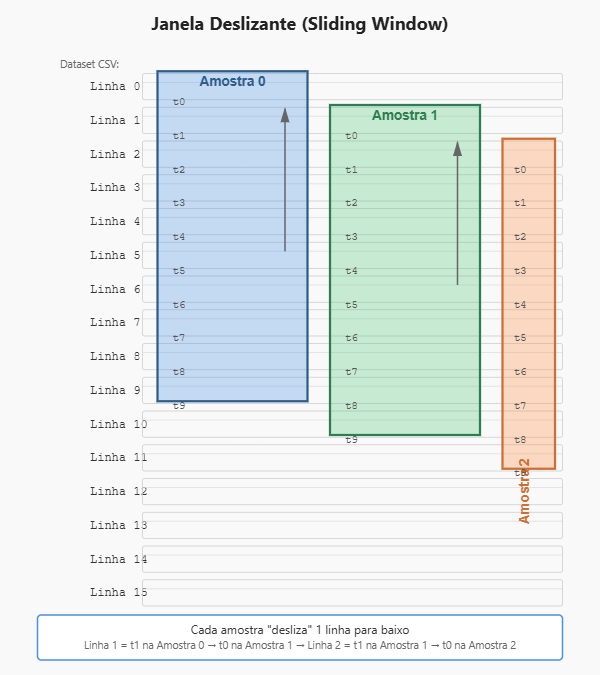

## 3.2. Divisão em Treino, Validação e Teste

**Divisão:**
- Treino: 70% dos dados (para treinar o modelo)
- Validação: 15% dos dados (para ajustar hiperparâmetros)
- Teste: 15% dos dados (para avaliar desempenho final)

In [44]:
#Dividir dados em treino, validação e teste
train_size = int(0.7 * len(X))
val_size = int(0.85 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:val_size], y[train_size:val_size]
X_test, y_test = X[val_size:], y[val_size:]

print('Dados divididos:')
print(f'  Treino:    {len(X_train):6d} amostras ({100*len(X_train)/len(X):.1f}%)')
print(f'  Validação: {len(X_val):6d} amostras ({100*len(X_val)/len(X):.1f}%)')
print(f'  Teste:     {len(X_test):6d} amostras ({100*len(X_test)/len(X):.1f}%)')

Dados divididos:
  Treino:     57673 amostras (70.0%)
  Validação:  12359 amostras (15.0%)
  Teste:      12359 amostras (15.0%)


## 3.3. Normalização dos Dados

**Por que normalizar?**
- Features têm escalas diferentes (temperatura ~20°C, pressão ~920 hPa)
- Redes neurais aprendem melhor com dados normalizados
- Evita que features com valores grandes dominem o treinamento

**Método:** StandardScaler (Z-score normalization)
- Transforma dados para média = 0 e desvio padrão = 1
- Fórmula: (x - média) / desvio_padrão

In [45]:
scaler = StandardScaler()# Normalizar dados usando StandardScaler

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1]) #Transforma dados 3D (amostras, timesteps, features) em 2D (amostras*timesteps, features)
#Necessário porque StandardScaler trabalha com dados 2D
scaler.fit(X_train_reshaped) #Calcula média e desvio padrão de cada feature usando APENAS dados de treino
#Aprende os parâmetros de normalização

#aplica (x - média) / desvio para cada feature
# Processo: reshape para 2D → normaliza → reshape de volta para 3D
#Os MESMOS parâmetros aprendidos no treino são aplicados em val e test
X_train_scaled = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
print(f'\nParâmetros do scaler:')
print(f'  Média (treino): {X_train_scaled.mean():.6f}')
print(f'  Desvio (treino): {X_train_scaled.std():.6f}')
print(f'\nMédias por feature:')
for i, name in enumerate(features):
    print(f'  {name:20s}: mean={scaler.mean_[i]:8.4f}, std={scaler.scale_[i]:8.4f}')


Parâmetros do scaler:
  Média (treino): 0.000000
  Desvio (treino): 1.000000

Médias por feature:
  Temp_AHT20_C        : mean= 20.2761, std=  3.2941
  Umid_AHT20_pct      : mean= 66.7186, std= 13.4807
  Temp_BMP280_C       : mean= 21.7595, std=  3.1919
  Press_BMP280_hPa    : mean=918.0153, std=  2.1066


A normalização funcionou corretamente (média=0, desvio=1), e os valores originais do conjunto de treino (Temp_AHT20: 20.28°C, Umid: 66.72%, Temp_BMP280: 21.76°C, Press: 918.02 hPa) diferem ligeiramente do dataset completo (20.33°C, 65.95%, 21.80°C, ~918.15 hPa) com variações menores que 2%. Essas pequenas diferenças ocorrem porque o scaler foi treinado apenas com 70% dos dados (conjunto de treino), enquanto as estatísticas anteriores consideravam 100% do dataset, indicando que a divisão train/val/test foi bem balanceada e os dados estão uniformemente distribuídos entre os conjuntos.

In [46]:
X_train_scaled

array([[[-0.11417314,  0.49340001, -0.15023965,  1.53074688],
        [-0.09292321,  0.65659648, -0.08758078,  1.47378383],
        [-0.15970871,  0.56312941, -0.15963848,  1.5117592 ],
        ...,
        [-0.32363676,  0.68255956, -0.31628567,  1.51650612],
        [-0.36613662,  0.72187507, -0.36641277,  1.52599996],
        [-0.35702951,  0.72335867, -0.36327982,  1.49277151]],

       [[-0.09292321,  0.65659648, -0.08758078,  1.47378383],
        [-0.15970871,  0.56312941, -0.15963848,  1.5117592 ],
        [-0.2204228 ,  0.59725231, -0.21603147,  1.48802459],
        ...,
        [-0.36613662,  0.72187507, -0.36641277,  1.52599996],
        [-0.35702951,  0.72335867, -0.36327982,  1.49277151],
        [-0.38435085,  0.74412913, -0.38521043,  1.49277151]],

       [[-0.15970871,  0.56312941, -0.15963848,  1.5117592 ],
        [-0.2204228 ,  0.59725231, -0.21603147,  1.48802459],
        [-0.20524428,  0.62098998, -0.20036675,  1.5354938 ],
        ...,
        [-0.35702951,  0.72

# 4. Construção e Treinamento do Modelo

---

## 4.1. Arquitetura do Modelo CNN 1D

**Por que CNN 1D?**
- Captura padrões temporais em dados sequenciais
- Mais leve que LSTM/GRU
- Compatível com TensorFlow Lite Micro

**Arquitetura:**
```
Input (10 timesteps × 4 features)
    |
Conv1D(24 filtros, kernel=3) + ReLU + Dropout(0.2)
    |
Conv1D(16 filtros, kernel=3) + ReLU
    |
GlobalAveragePooling1D
    |
Dense(24) + ReLU + Dropout(0.2)
    |
Dense(3) [Output: 3 previsões]
```

In [47]:
# Construir modelo CNN 1D
model = Sequential([
    # Primeira camada convolucional - extrai padrões temporais locais
    Conv1D(24, kernel_size=3, activation='relu', 
           kernel_regularizer=regularizers.l2(0.0001),#Regularização L2 para evitar overfitting
           input_shape=(WINDOW_SIZE, 4),  #Entrada: janela temporal com 4 features
           name='conv1d_1'),
    
    #Dropout para reduzir overfitting (desliga 20% dos neurônios)
    Dropout(0.2, name='dropout_1'),
    
    #Segunda camada convolucional - captura padrões mais complexos
    Conv1D(16, kernel_size=3, activation='relu',
           kernel_regularizer=regularizers.l2(0.0001),
           name='conv1d_2'),

    GlobalAveragePooling1D(name='global_avg_pool'), #Achata os dados 2D (timesteps, filtros) em vetor 1D para camada Dense
    
    #Camada densa para combinar features extraídas
    Dense(24, activation='relu', 
          kernel_regularizer=regularizers.l2(0.0001),
          name='dense_1'),
    
    #Segundo dropout
    Dropout(0.2, name='dropout_2'),
    
    #Camada de saída - 3 valores (previsões para 3 horizontes temporais)
    Dense(3, activation='linear', name='output')
], name='CNN1D_Temperature')
# Compilar modelo
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

print('\nArquitetura:')
model.summary()

print(f'\nTotal de parâmetros: {model.count_params():,}')


Arquitetura:


Model: "CNN1D_Temperature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 8, 24)          │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 24)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 6, 16)          │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            75 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,963 (7.67 KB)

 Trainable params: 1,963 (7.67 KB)

 Non-trainable params: 0 (0.00 B)


Total de parâmetros: 1,963


## 4.2. Configurar Callbacks

**Callbacks** são funções que executam durante o treinamento:

1. **EarlyStopping**: Para o treinamento se a validação não melhorar
2. **ReduceLROnPlateau**: Reduz learning rate quando estagnar

In [48]:
# Configurar callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=50, #aguarda 50 epocas sem melhora no val_loss antes de para
        restore_best_weights=True, #restaura pesos da melhor epoca
        verbose=1#mostra quando para
    ), 
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5, #reduz learning rate pela metade
        patience=20, #aguarda 20 epoca sem melhorar antes de reduzir
        min_lr=1e-7, #minimo
        verbose=1 #mostrar quando reduzir
    )
]

## 4.3. Treinar o Modelo

In [49]:
history = model.fit( #treinamento modelo
    X_train_scaled, y_train, # x e y de treino sendo x o normalizado
    validation_data=(X_val_scaled, y_val), #dados de validação
    epochs=300, #300 epoca
    batch_size=512,#Pega 512 amostras do dataset -> 113 interações, grandiente mais estavel
    callbacks=callbacks, #Callbacks mostrado a cima
    verbose=1 #mostra andamento
)

Epoch 1/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 375.5785 - mae: 19.0334 - val_loss: 269.0462 - val_mae: 16.0135 - learning_rate: 5.0000e-04
Epoch 2/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 109.5426 - mae: 8.9777 - val_loss: 71.6875 - val_mae: 7.5941 - learning_rate: 5.0000e-04
Epoch 3/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 57.0030 - mae: 6.2311 - val_loss: 36.0035 - val_mae: 5.1674 - learning_rate: 5.0000e-04
Epoch 4/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 35.5809 - mae: 4.8662 - val_loss: 17.8464 - val_mae: 3.5302 - learning_rate: 5.0000e-04
Epoch 5/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 24.8139 - mae: 4.0016 - val_loss: 8.5390 - val_mae: 2.4496 - learning_rate: 5.0000e-04
Epoch 6/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 18.5737 - mae: 3.3944 - val_loss: 3.7898 - val_mae: 1.6483 - learning_rate: 5.0000e-04
Epoch 7/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.4613 - mae: 3.0773 - val_loss: 2.1255 -

## 4.4. Visualizar Curvas de Aprendizado

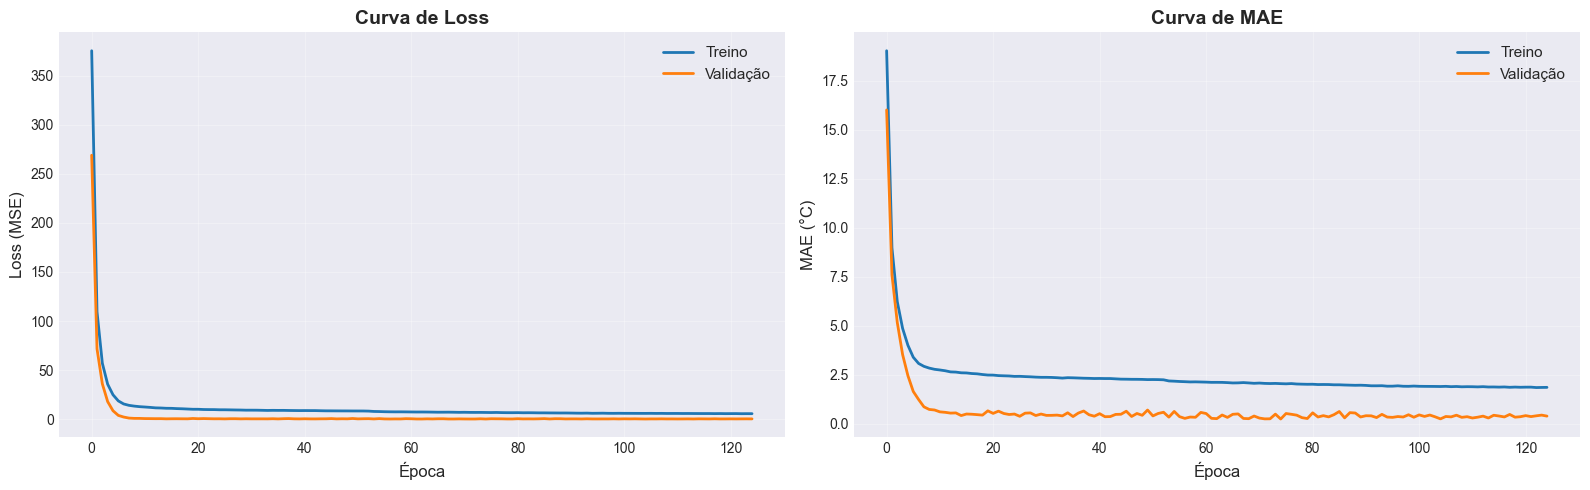

In [50]:
# Plotar curvas de loss e MAE
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history.history['loss'], label='Treino', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validação', linewidth=2)
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Curva de Loss', fontweight='bold', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Treino', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validação', linewidth=2)
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('MAE (°C)', fontsize=12)
axes[1].set_title('Curva de MAE', fontweight='bold', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/Conv1D/04_curvas_aprendizado.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Avaliação do Modelo

---

## 5.1. Métricas no Conjunto de Teste

**Métricas utilizadas:**
- **MAE** (Mean Absolute Error): Erro médio absoluto em °C
- **RMSE** (Root Mean Squared Error): Raiz do erro quadrático médio
- **R²** (Coefficient of Determination): Quanto o modelo explica a variância

In [51]:
y_pred = model.predict(X_test_scaled, verbose=0)#Fazer predições no conjunto de teste
# Calcular métricas gerais no conjunto de teste
mae_overall = mean_absolute_error(y_test, y_pred)
rmse_overall = np.sqrt(mean_squared_error(y_test, y_pred))
r2_overall = r2_score(y_test, y_pred)

# Calcular MAE por horizonte
mae_t1 = mean_absolute_error(y_test[:, 0], y_pred[:, 0]) #5 minutos
mae_t2 = mean_absolute_error(y_test[:, 1], y_pred[:, 1])#10 minutos
mae_t3 = mean_absolute_error(y_test[:, 2], y_pred[:, 2]) #15 minutos

print(f'\nMétricas Gerais:')
print(f'  MAE:  {mae_overall:.4f} °C')
print(f'  RMSE: {rmse_overall:.4f} °C')
print(f'  R²:   {r2_overall:.4f}')
print(f'\nMAE por Horizonte:')
print(f'  T+10 (5 min):   {mae_t1:.4f} °C')
print(f'  T+19 (10 min):  {mae_t2:.4f} °C')
print(f'  T+29 (15 min):  {mae_t3:.4f} °C')
print(f'\nInformações do Modelo:')
print(f'  Parâmetros totais: {model.count_params():,}')


Métricas Gerais:
  MAE:  0.3461 °C
  RMSE: 0.4292 °C
  R²:   0.9857

MAE por Horizonte:
  T+10 (5 min):   0.2910 °C
  T+19 (10 min):  0.3439 °C
  T+29 (15 min):  0.4033 °C

Informações do Modelo:
  Parâmetros totais: 1,963


## 5.2. Gráficos de Predito vs Real

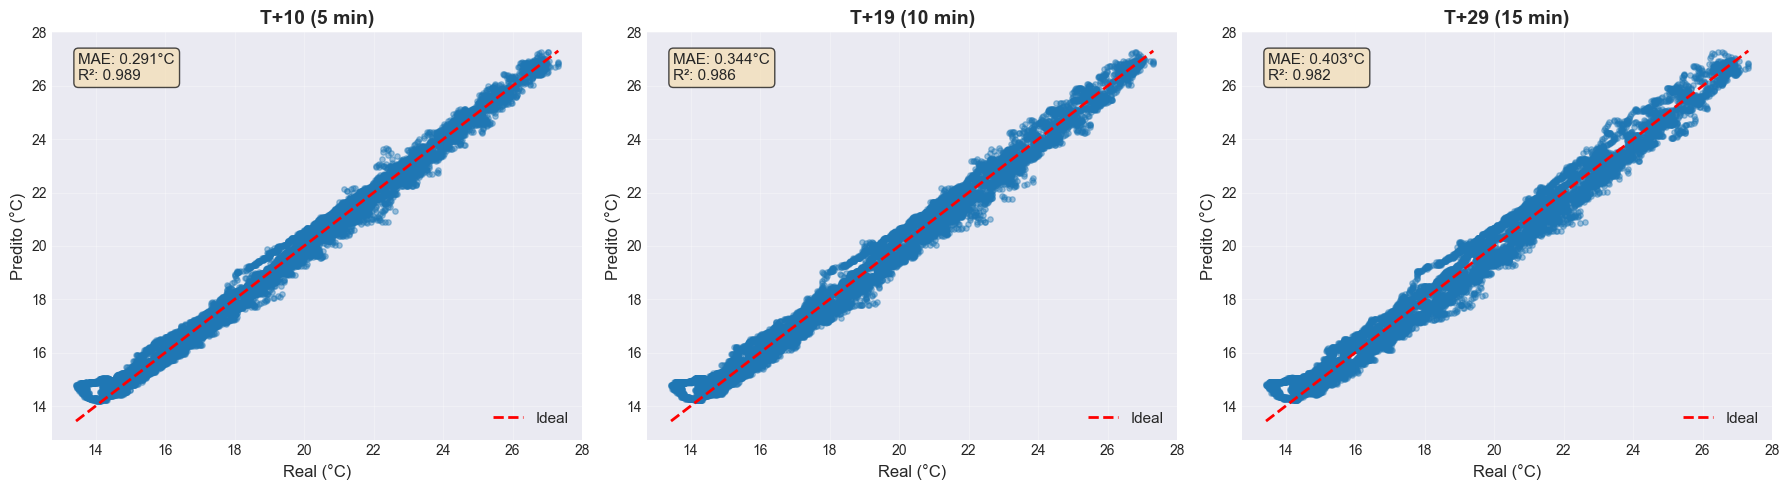

Gráfico salvo: images/Conv1D/05_scatter_predictions.png


In [52]:
# Plotar scatter plots para cada horizonte
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

horizons_names = ['T+10 (5 min)', 'T+19 (10 min)', 'T+29 (15 min)']

for i, (horizon_name, ax) in enumerate(zip(horizons_names, axes)):
    ax.scatter(y_test[:, i], y_pred[:, i], alpha=0.4, s=15)
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideal')
    ax.set_xlabel('Real (°C)', fontsize=12)
    ax.set_ylabel('Predito (°C)', fontsize=12)
    ax.set_title(horizon_name, fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    ax.text(0.05, 0.95, f'MAE: {mae:.3f}°C\nR²: {r2:.3f}',
            transform=ax.transAxes, va='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('images/Conv1D/05_scatter_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/Conv1D/05_scatter_predictions.png')

## 5.3. Séries Temporais de Predições

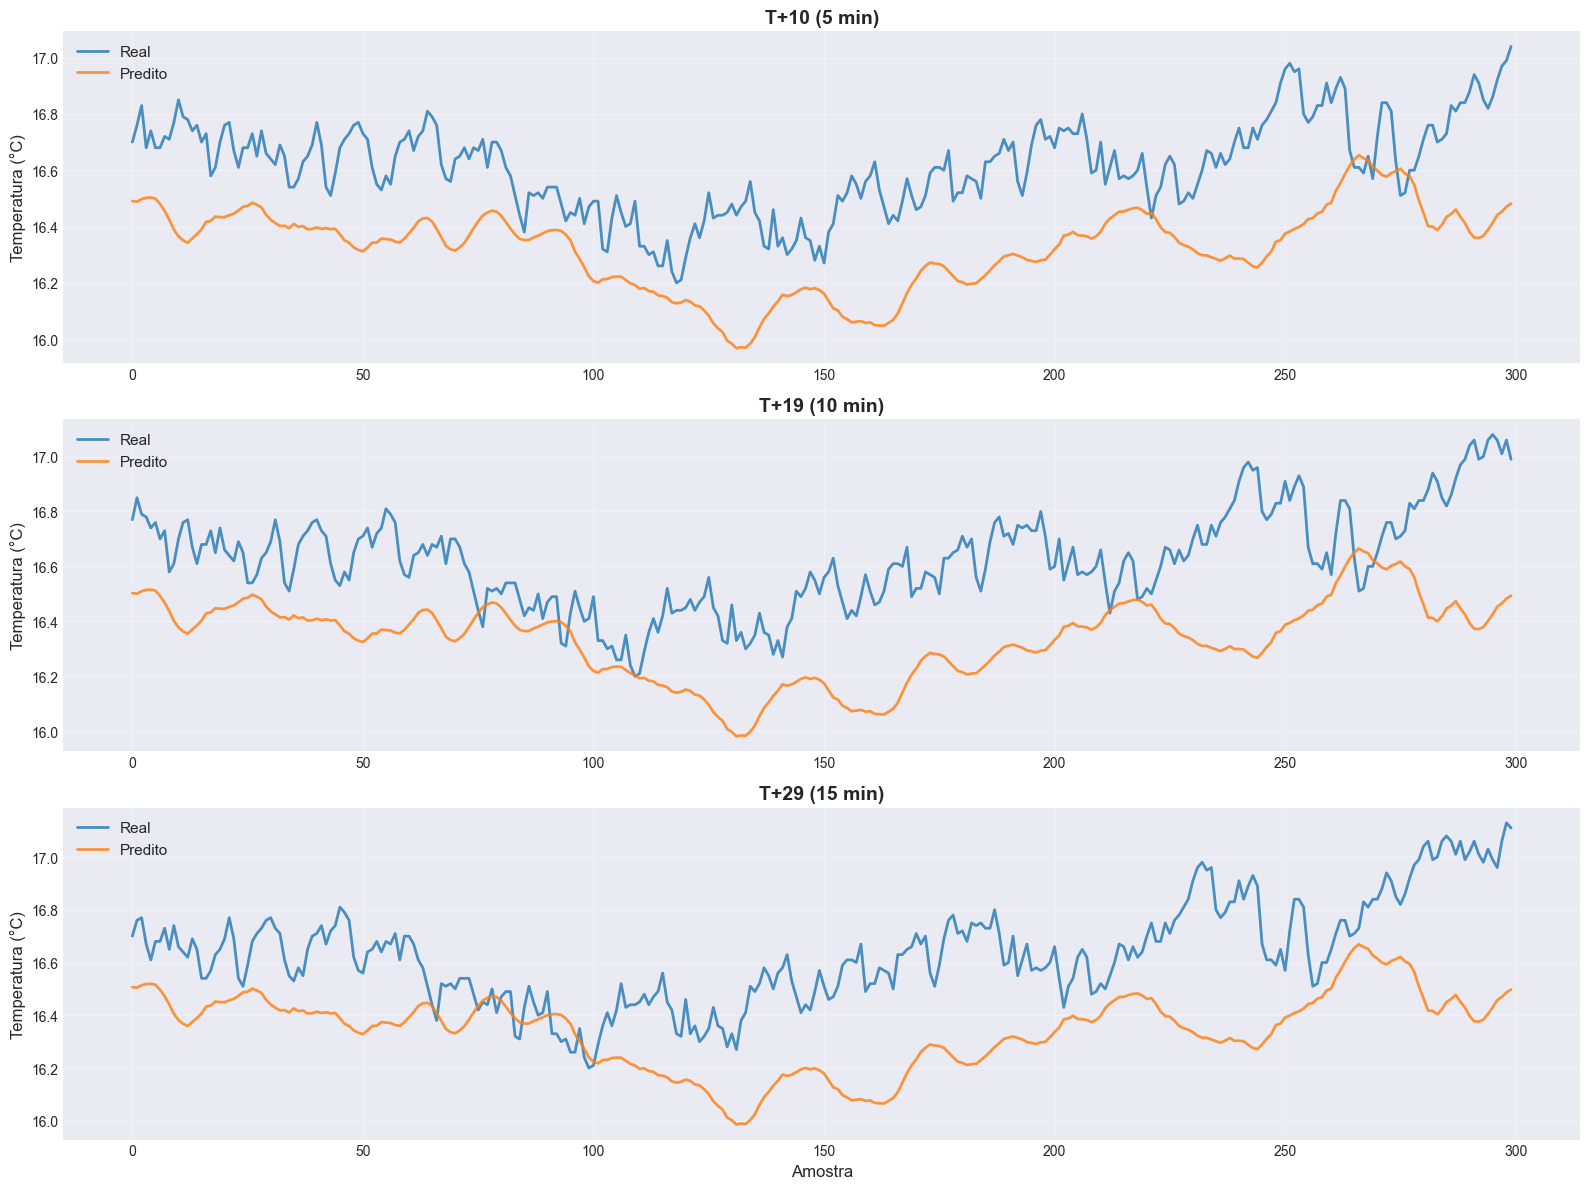

Gráfico salvo: images/Conv1D/06_timeseries_predictions.png


In [53]:
# Plotar série temporal das predições
n_samples = 300
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for i, (horizon_name, ax) in enumerate(zip(horizons_names, axes)):
    ax.plot(y_test[:n_samples, i], label='Real', linewidth=2, alpha=0.8)
    ax.plot(y_pred[:n_samples, i], label='Predito', linewidth=2, alpha=0.8)
    ax.set_ylabel('Temperatura (°C)', fontsize=12)
    ax.set_title(horizon_name, fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

axes[2].set_xlabel('Amostra', fontsize=12)
plt.tight_layout()
plt.savefig('images/Conv1D/06_timeseries_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/Conv1D/06_timeseries_predictions.png')

## 5.4. Análise de Erros

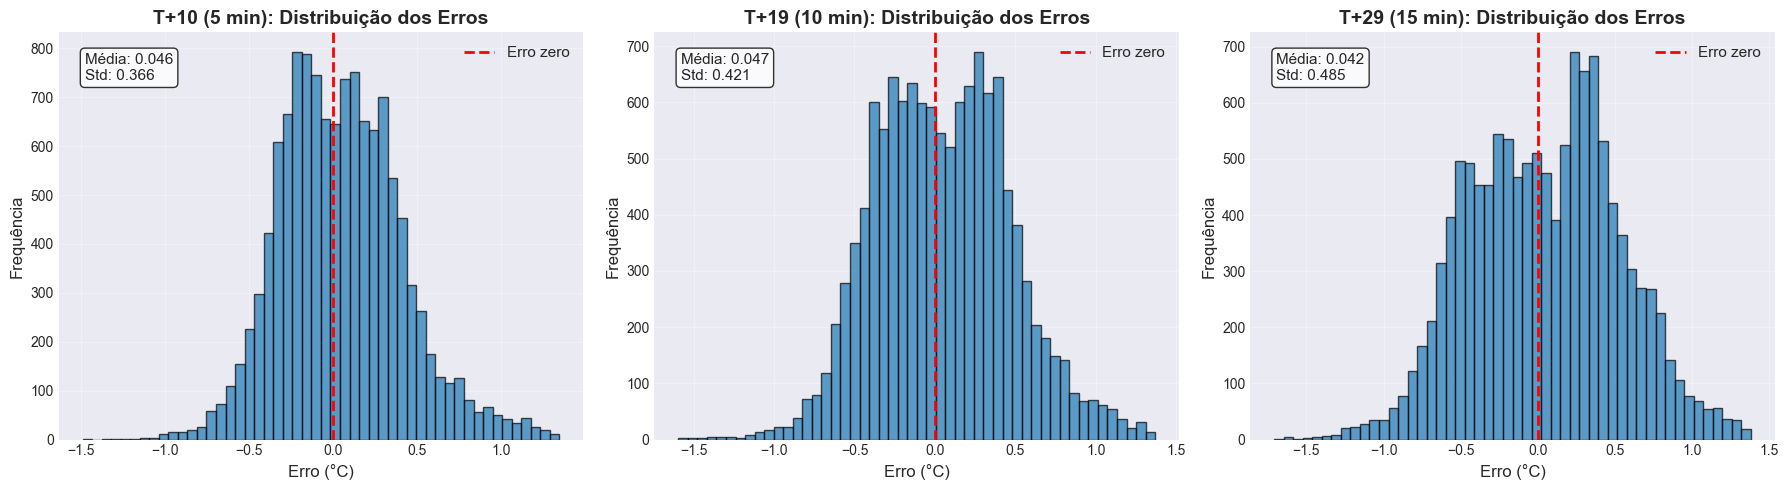

Gráfico salvo: images/Conv1D/07_error_distribution.png


In [54]:
# Calcular erros
errors = y_pred - y_test

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (horizon_name, ax) in enumerate(zip(horizons_names, axes)):
    ax.hist(errors[:, i], bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Erro zero')
    ax.set_xlabel('Erro (°C)', fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.set_title(f'{horizon_name}: Distribuição dos Erros', fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    mean_err = errors[:, i].mean()
    std_err = errors[:, i].std()
    ax.text(0.05, 0.95, f'Média: {mean_err:.3f}\nStd: {std_err:.3f}',
            transform=ax.transAxes, va='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('images/Conv1D/07_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/Conv1D/07_error_distribution.png')

# 6. Conversão para TensorFlow Lite

---

## 6.1. Salvar Modelo Original

In [55]:
# Criar pasta models/Conv1D se não existir
os.makedirs('models/Conv1D', exist_ok=True)

model.save('models/Conv1D/temperature_model.keras')
print('Modelo Keras salvo: models/Conv1D/temperature_model.keras')

Modelo Keras salvo: models/Conv1D/temperature_model.keras


## 6.2. Converter para TensorFlow Lite

In [56]:
# Converter para TFLite (SEM quantização - float32 puro)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]  
tflite_model = converter.convert()

with open('models/Conv1D/temperature_model.tflite', 'wb') as f:
    f.write(tflite_model)

size_kb = len(tflite_model) / 1024
print(f'Modelo TFLite salvo: models/Conv1D/temperature_model.tflite')
print(f'Tamanho: {size_kb:.2f} KB')

if size_kb < 100:
    print('Compatível com Raspberry Pi Pico (2MB Flash)')
else:
    print('AVISO: Modelo grande para microcontrolador')

INFO:tensorflow:Assets written to: C:\Users\Jonas\AppData\Local\Temp\tmplc5v4xjh\assets


INFO:tensorflow:Assets written to: C:\Users\Jonas\AppData\Local\Temp\tmplc5v4xjh\assets


Saved artifact at 'C:\Users\Jonas\AppData\Local\Temp\tmplc5v4xjh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 4), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2155477468752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2155477482576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2155477476816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2155477483152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2155477483344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2155477468944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2155477478352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2155477471056: TensorSpec(shape=(), dtype=tf.resource, name=None)
Modelo TFLite salvo: models/Conv1D/temperature_model.tflite
Tamanho: 11.77 KB
Compatível com Raspberry Pi Pico (2MB Flash)


## 6.3. Verificar Conversão TFLite

In [57]:
# Testar modelo TFLite
interpreter = tf.lite.Interpreter(model_path='models/Conv1D/temperature_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print('Informações do modelo TFLite:')
print(f'  Input shape:  {input_details[0]["shape"]}')
print(f'  Input dtype:  {input_details[0]["dtype"]}')
print(f'  Output shape: {output_details[0]["shape"]}')
print(f'  Output dtype: {output_details[0]["dtype"]}')

test_sample = X_test_scaled[0:1].astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], test_sample)
interpreter.invoke()
tflite_pred = interpreter.get_tensor(output_details[0]['index'])

keras_pred = model.predict(test_sample, verbose=0)

print(f'\nTeste de conversão:')
print(f'  Predição Keras:  {keras_pred[0]}')
print(f'  Predição TFLite: {tflite_pred[0]}')
print(f'  Diferença máxima: {np.abs(keras_pred - tflite_pred).max():.6f} °C')

if np.abs(keras_pred - tflite_pred).max() < 0.01:
    print('\nConversão TFLite: OK')
else:
    print('\nAVISO: Diferença significativa após conversão')

Informações do modelo TFLite:
  Input shape:  [ 1 10  4]
  Input dtype:  <class 'numpy.float32'>
  Output shape: [1 3]
  Output dtype: <class 'numpy.float32'>

Teste de conversão:
  Predição Keras:  [16.490503 16.502966 16.50691 ]
  Predição TFLite: [16.490503 16.502966 16.50691 ]
  Diferença máxima: 0.000000 °C

Conversão TFLite: OK


# 7. Geração de Arquivo C para RP2040

---

## 7.1. Converter Modelo TFLite para C Array

In [58]:
def convert_to_c_array(tflite_model, var_name='model_data'):#Cria um array de bytes em formato C
    c_array = f"const unsigned char {var_name}[] = {{\n"#array de bytes constante (fica na memória flash)
    for i in range(0, len(tflite_model), 12): # # Percorre de 12 em 12 bytes
        line = "  "
        for j in range(12):## Coloca 12 bytes por linha
            if i + j < len(tflite_model):
                line += f"0x{tflite_model[i+j]:02x}, "## Formato hexadecimal
        c_array += line + "\n"
    c_array += "};\n"
    c_array += f"const unsigned int {var_name}_len = {len(tflite_model)};\n"
    return c_array
#Criação do arquivo .h:
h_content = """// Temperature Prediction Model - TinyML 
// Auto-generated file - Do not edit manually
// Model trained on AHT20 + BMP280 sensor data

#ifndef TEMPERATURE_MODEL_H
#define TEMPERATURE_MODEL_H

// Model information
#define WINDOW_SIZE 10
#define NUM_FEATURES 4
#define NUM_HORIZONS 3

// Feature names
const char* feature_names[] = {
    "Temp_AHT20_C",
    "Umid_AHT20_pct",
    "Temp_BMP280_C",
    "Press_BMP280_hPa"
};

// Horizon names
const char* horizon_names[] = {
    "5 minutes",
    "10 minutes",
    "15 minutes"
};

"""

h_content += convert_to_c_array(tflite_model, 'temperature_model')#Insere o array de bytes do modelo

h_content += """
#endif // TEMPERATURE_MODEL_H
"""

h_filename = 'models/Conv1D/temperature_model.h'
with open(h_filename, 'w') as f:
    f.write(h_content)

print(f'Arquivo {h_filename} gerado com sucesso!')
print(f'Tamanho do modelo: {len(tflite_model)} bytes ({len(tflite_model)/1024:.2f} KB)')

Arquivo models/Conv1D/temperature_model.h gerado com sucesso!
Tamanho do modelo: 12056 bytes (11.77 KB)


## 7.2. Gerar Parâmetros do Scaler para C

In [59]:
# Gerar arquivo header com parâmetros de normalização
#COMO AS VARIAVEIS FORAM NORMALIZADAS NO TREINAMENTO, É NECESSARIO ESSES PARAMETROS DE NORMALIZAÇÃO
#PARA O PICO APLICAR TAMBEM
scaler_h_content = """// Scaler parameters for normalization
// Auto-generated file - Do not edit manually

#ifndef SCALER_PARAMS_H
#define SCALER_PARAMS_H

// Mean values
const float scaler_mean[] = {
"""

for i, mean_val in enumerate(scaler.mean_):
    scaler_h_content += f"    {mean_val:.6f}f"
    if i < len(scaler.mean_) - 1:
        scaler_h_content += ","
    scaler_h_content += f"  // {features[i]}\n"

scaler_h_content += """};\n
// Scale values
const float scaler_scale[] = {
"""

for i, scale_val in enumerate(scaler.scale_):
    scaler_h_content += f"    {scale_val:.6f}f"
    if i < len(scaler.scale_) - 1:
        scaler_h_content += ","
    scaler_h_content += f"  // {features[i]}\n"

scaler_h_content += """};\n
#endif // SCALER_PARAMS_H
"""

scaler_filename = 'models/Conv1D/scaler_params.h'
with open(scaler_filename, 'w') as f:
    f.write(scaler_h_content)

print(f'\nParâmetros do Scaler:')
print(f'  Mean: {scaler.mean_}')
print(f'  Scale: {scaler.scale_}')


Parâmetros do Scaler:
  Mean: [ 20.27610098  66.71863049  21.75954788 918.01528488]
  Scale: [ 3.29412826 13.48068374  3.19188629  2.10662857]


## 7.3. Salvar Scaler

In [60]:
import joblib

joblib.dump(scaler, 'models/Conv1D/scaler.pkl')

['models/Conv1D/scaler.pkl']